# EuroSAT_MS — Local Conventional ML Baseline

Ported from the original Colab workflow to run directly on macOS/Apple Silicon with the local dataset + Kaggle test tiles.


## 1) Environment Setup

Configure local paths (dataset, Kaggle test set, outputs) instead of relying on Google Drive.


### Cell 2 – Import dependencies
Loads datetime/path utilities, NumPy/Pandas/matplotlib, rasterio, and scikit-learn pieces used throughout the local workflow.


In [1]:
from datetime import datetime
from pathlib import Path
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    auc,
)


### Cell 3 – Resolve environment paths
Defines `_env_path`, resolves dataset/outputs directories, creates needed folders, and validates that EuroSAT data exists.


In [2]:
def _env_path(var_name: str, default: Path) -> Path:
    default_path = Path(default)
    value = os.environ.get(var_name)
    return Path(value).expanduser() if value else default_path

REPO_ROOT = Path.cwd()
DATA_BASE = _env_path('EUROSAT_DATA_BASE', Path('/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project'))
DATA_ROOT = _env_path('EUROSAT_DATA_ROOT', DATA_BASE / 'EuroSAT_MS')
KAGGLE_TEST_DIR = _env_path('EUROSAT_KAGGLE_TEST_DIR', DATA_BASE / 'kaggle_data' / 'testset' / 'testset')
OUTPUT_DIR = _env_path('EUROSAT_OUTPUT_DIR', REPO_ROOT / 'cc_1' / 'outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR = OUTPUT_DIR / 'plots'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Dataset directory {DATA_ROOT} does not exist. Update EUROSAT_DATA_ROOT or extract EuroSAT_MS there.")

print(f"DATA_ROOT={DATA_ROOT}")
print(f"KAGGLE_TEST_DIR={KAGGLE_TEST_DIR}")
print(f"OUTPUT_DIR={OUTPUT_DIR}")
print(f"PLOT_DIR={PLOT_DIR}")


DATA_ROOT=/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/EuroSAT_MS
KAGGLE_TEST_DIR=/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/kaggle_data/testset/testset
OUTPUT_DIR=/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/cc_1/outputs
PLOT_DIR=/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/cc_1/outputs/plots


## 2) Configuration & Utilities


### Cell 5 – Run bookkeeping setup
Captures the random seed and timestamp, seeds Python and NumPy RNGs, and logs the configuration for reproducibility.


In [3]:
RANDOM_SEED = 42
RUN_TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(f"Random seed set to {RANDOM_SEED}")
print(f"Run timestamp: {RUN_TIMESTAMP}")


Random seed set to 42
Run timestamp: 20251210_143936


## 3) Load GeoTIFFs and Visualize (RGB, NDVI, Bands)


### Cell 7 – Read and normalize GeoTIFFs
Implements `read_multiband_tif` to load Sentinel-2 tiles and normalize each band into [0,1].


In [4]:
def read_multiband_tif(path):
    with rasterio.open(path) as src:
        arr = src.read()  # (C,H,W)
        arr = arr.astype(np.float32)
        # robust per-band normalization to [0,1]
        C,H,W = arr.shape
        for i in range(C):
            band = arr[i]
            lo, hi = np.percentile(band, [2, 98])
            if hi > lo:
                band = (band - lo) / (hi - lo)
            else:
                bmin, bmax = band.min(), band.max()
                band = (band - bmin) / (bmax - bmin + 1e-6)
            arr[i] = np.clip(band, 0.0, 1.0)
        return arr

### Cell 8 – Compute NDVI
Provides the `ndvi_from_arr` helper based on the red and NIR bands.


In [5]:
def ndvi_from_arr(arr):
    nir = arr[7]  # B8
    red = arr[3]  # B4
    return (nir - red) / (nir + red + 1e-6)

### Cell 9 – Visualize representative tile
Plots both RGB and NDVI for a given path to sanity-check preprocessing.


In [6]:
def show_sample(path, title="Sample"):
    arr = read_multiband_tif(path)
    rgb = np.stack([arr[3], arr[2], arr[1]], axis=-1)  # B4,B3,B2
    ndvi = ndvi_from_arr(arr)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(np.clip(rgb,0,1)); plt.title(f"{title} – RGB"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(ndvi, cmap="RdYlGn"); plt.title("NDVI"); plt.axis("off")
    plt.show()

### Cell 10 – Enumerate dataset
Builds `CLASS_NAMES`, collects all `(path, label)` pairs, and prints dataset statistics.


### Cell 11 – Align EuroSAT (13-band) and Kaggle (12-band) layouts
EuroSAT training tiles provide 13 Sentinel-2 bands (`B1`…`B12` + `B8A`), but the Kaggle `testset` ships only 12 bands and omits `B10`. This block spells out both band orders, marks `B10` as the dropped channel, and builds helper index arrays. `TRAIN_BAND_ORDER` is the canonical training order, `TEST_BAND_ORDER` mirrors the Kaggle `.npy` layout, `CANONICAL_12_BAND_ORDER` removes `B10`, and `TEST_TO_CANONICAL_12` tells us how to permute a Kaggle tile into the canonical 12-band arrangement. Knowing the `DROP_BAND_INDEX` lets later helpers insert a zero-filled B10 plane so every downstream feature extractor still receives 13 bands, even though the raw test data is missing one of them.


In [7]:
CLASS_NAMES = []
samples = []

if DATA_ROOT.exists():
    class_dirs = sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()])
    for d in class_dirs:
        label = len(CLASS_NAMES)
        CLASS_NAMES.append(d.name)
        for tif_path in sorted(d.glob('*.tif')):
            samples.append((tif_path, label))
else:
    raise FileNotFoundError(f"{DATA_ROOT} not found. Extract the archive first.")

CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}

print(f"Detected {len(CLASS_NAMES)} classes")
print(f"Total samples: {len(samples)}")

TRAIN_BAND_ORDER = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B8A']
TEST_BAND_ORDER = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
DROP_BAND_NAME = 'B10'
DROP_BAND_INDEX = TRAIN_BAND_ORDER.index(DROP_BAND_NAME)
CANONICAL_12_BAND_ORDER = [band for band in TRAIN_BAND_ORDER if band != DROP_BAND_NAME]
TEST_TO_CANONICAL_12 = np.array([CANONICAL_12_BAND_ORDER.index(band) for band in TEST_BAND_ORDER], dtype=np.int64)


Detected 10 classes
Total samples: 27000


### Cell 11 – Reorder Kaggle test bands
Adds `reorder_test_to_canonical` to map Kaggle's 12-band ordering into the canonical training layout.


In [8]:
def reorder_test_to_canonical(arr: np.ndarray) -> np.ndarray:
    """Reorder 12-band L2A tiles (test layout) to the canonical 12-band training layout (without B10)."""
    arr = np.asarray(arr)
    if arr.shape[0] != len(TEST_BAND_ORDER):
        raise ValueError(f"Expected array with {len(TEST_BAND_ORDER)} bands, got {arr.shape[0]}")
    out = np.empty((len(CANONICAL_12_BAND_ORDER), *arr.shape[1:]), dtype=arr.dtype)
    for src_idx, dst_idx in enumerate(TEST_TO_CANONICAL_12):
        out[dst_idx] = arr[src_idx]
    return out


### NDVI thresholding (vegetation mask)


### Cell 13 – Threshold NDVI
Defines a helper that converts continuous NDVI maps into binary vegetation masks for visualization.


In [9]:
def threshold_ndvi(ndvi, thr=0.3):
    return (ndvi > thr).astype(np.uint8)

### Cell 14 – Plot NDVI mask overlays
Shows RGB, NDVI, and the thresholded mask for the first available sample tile.


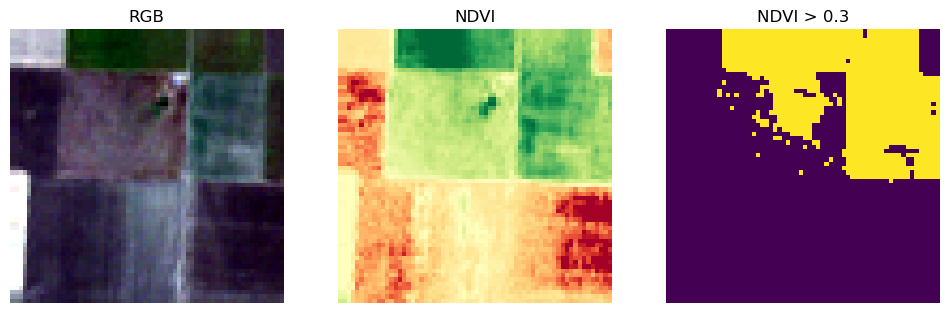

In [10]:
if samples:
    arr = read_multiband_tif(samples[0][0])
    ndvi = ndvi_from_arr(arr)
    mask = threshold_ndvi(ndvi, thr=0.3)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(np.stack([arr[3],arr[2],arr[1]], axis=-1)); plt.title("RGB"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(ndvi, cmap="RdYlGn"); plt.title("NDVI"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(mask, interpolation="nearest"); plt.title("NDVI > 0.3"); plt.axis("off")
    plt.show()


### Per-band inspection


### Cell 16 – Per-band visualization helper
Creates `show_bands` to display every spectral band on a grid.


In [11]:
def show_bands(arr):
    import math
    cols = 4
    rows = math.ceil(arr.shape[0]/cols)
    plt.figure(figsize=(12, 3*rows))
    for i in range(arr.shape[0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow(arr[i])
        plt.title(f"Band {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### Cell 17 – Display all bands for a tile
Applies `show_bands` to the first sample to inspect band quality.


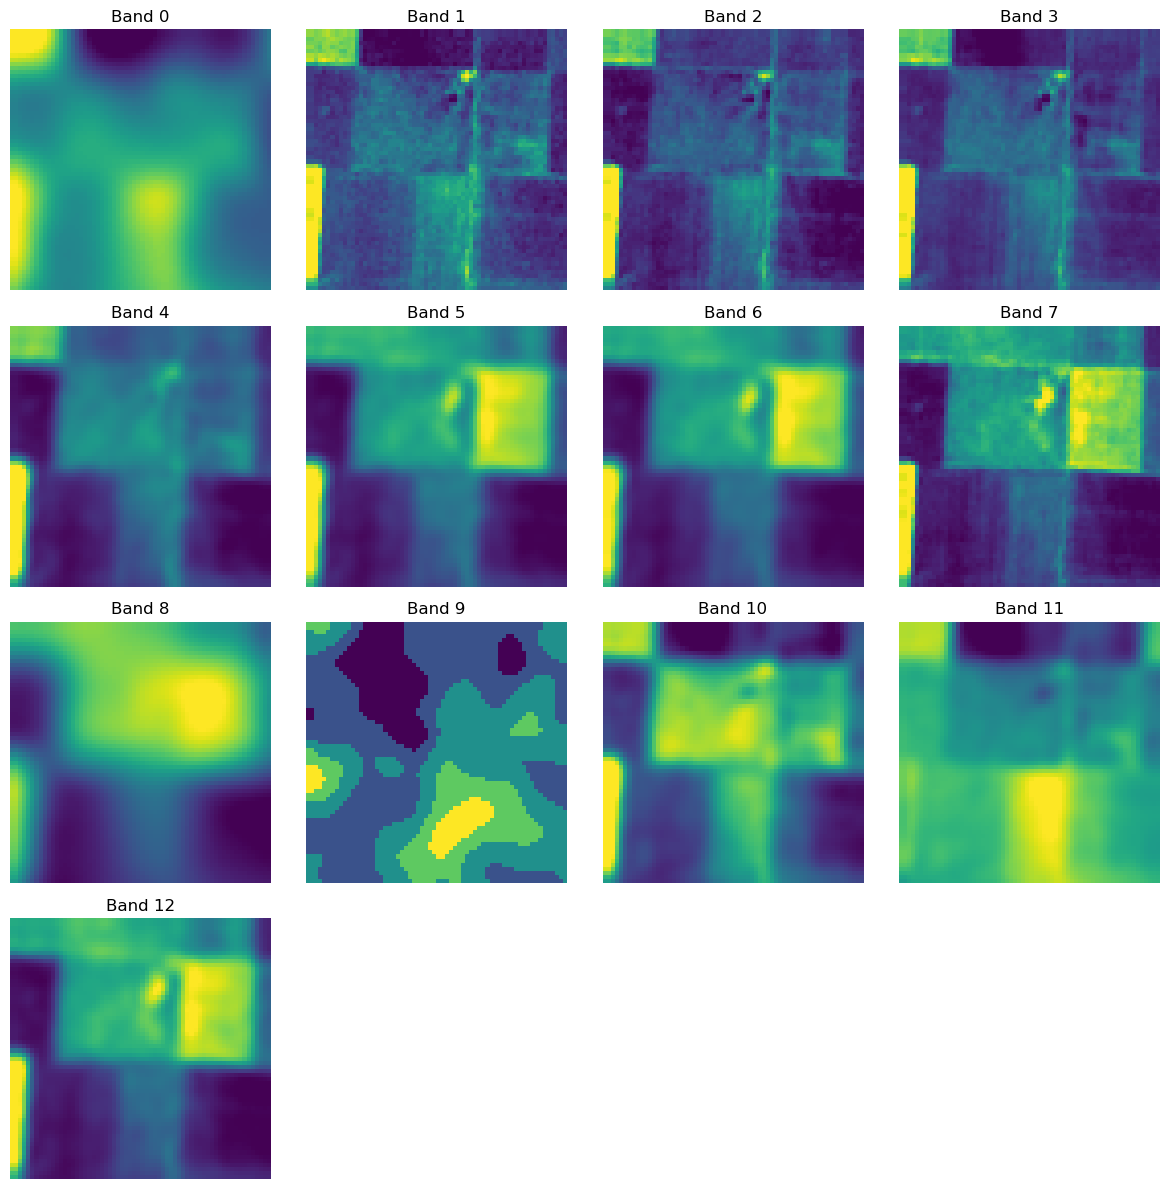

In [12]:
if samples:
    arr = read_multiband_tif(samples[0][0])
    show_bands(arr)


## 4) Feature Engineering for Conventional ML


### Cell 19 – Statistical feature builder
This block explains **how** we distill each 13-band tile into a compact feature vector. The helper iterates over every band, computing mean, std, and inter-quartile stats so the classifier sees distributional cues instead of raw pixels. It also derives NDVI for vegetation context and concatenates everything (plus optional global descriptors) into one 1D array per tile, trading spatial detail for a fast, interpretable summary that classic ML pipelines can digest.


In [13]:
def image_features(arr):
    """Return a 1D feature vector using simple, fast statistics per band + NDVI."""
    feats = []
    # per-band stats
    for i in range(arr.shape[0]):
        band = arr[i]
        p25, p50, p75 = np.percentile(band, [25,50,75])
        feats.extend([band.mean(), band.std(), p25, p50, p75])
    # NDVI stats
    ndvi = ndvi_from_arr(arr)
    p25, p50, p75 = np.percentile(ndvi, [25,50,75])
    veg_ratio = (ndvi > 0.3).mean()
    feats.extend([ndvi.mean(), ndvi.std(), p25, p50, p75, veg_ratio])
    return np.array(feats, dtype=np.float32)

### Cell 20 – Flattened spatial features
Rather than hand the model full-resolution imagery, `downsampled_flat` strides through each band, downsamples it to a manageable grid (≈16×16), then flattens the stack. This preserves coarse spatial structure (textures/patterns) while keeping dimensionality low enough for PCA + linear models. The helper therefore bridges the gap between image-like inputs and tabular ML workflows.


In [14]:
# compact spatial features via downsampling then PCA later
def downsampled_flat(arr, target=16):
    # simple spatial downsample by stride to roughly target x target per band
    C,H,W = arr.shape
    sx = max(1, H//target)
    sy = max(1, W//target)
    small = arr[:, ::sx, ::sy]
    return small.reshape(-1)  # C * h * w

### Cell 21 – Assemble feature matrices
Here we loop over every `(path, label)` pair, load the GeoTIFF once, and feed it through both feature extractors. The resulting numpy arrays `X_stats` and `X_flat` store complementary views (per-band stats vs. downsampled pixels) aligned with the label vector `y` and file paths for later plotting/evaluation. This is the heavy lifting stage that turns thousands of tiles into ML-ready matrices.


In [15]:
# Build dataset matrices
X_stats, y, paths = [], [], []
X_flat = []
for p, lab in samples:
    a = read_multiband_tif(p)
    X_stats.append(image_features(a))
    X_flat.append(downsampled_flat(a, target=16))
    y.append(lab); paths.append(str(p))

X_stats = np.stack(X_stats) if X_stats else np.empty((0,))
X_flat  = np.stack(X_flat)  if X_flat  else np.empty((0,))
y = np.array(y)
print("Feature shapes -> stats:", X_stats.shape, "| flat (for PCA):", X_flat.shape, "| labels:", y.shape)


Feature shapes -> stats: (27000, 71) | flat (for PCA): (27000, 3328) | labels: (27000,)


## 5) Train/Validation/Test Split


### Cell 23 – Stratified dataset splits
Generates train/test and train/val indices, then slices each feature set plus metadata accordingly.


In [16]:
N = len(y)
idx = np.arange(N)

# 1) Train/Test (stratified)
idx_tr, idx_te = train_test_split(
    idx, test_size=0.20, random_state=RANDOM_SEED, stratify=y
)

# 2) Train/Val (stratified) — only within the training set
y_tr = y[idx_tr]
idx_tr_sub, idx_val_sub = train_test_split(
    idx_tr, test_size=0.20, random_state=RANDOM_SEED, stratify=y_tr
)

# Now slice ALL views (stats, flat, labels, paths) with the SAME indices
Xtr_stats, Xval_stats, Xte_stats = X_stats[idx_tr_sub], X_stats[idx_val_sub], X_stats[idx_te]
Xtr_flat,  Xval_flat,  Xte_flat  = X_flat[idx_tr_sub],  X_flat[idx_val_sub],  X_flat[idx_te]
ytr,       yval,       yte       = y[idx_tr_sub],       y[idx_val_sub],       y[idx_te]

paths_tr = [paths[i] for i in idx_tr_sub]
paths_val = [paths[i] for i in idx_val_sub]
paths_te  = [paths[i] for i in idx_te]

print("Stats features -> train/val/test:", Xtr_stats.shape, Xval_stats.shape, Xte_stats.shape)
print("Flat  features -> train/val/test:", Xtr_flat.shape,  Xval_flat.shape,  Xte_flat.shape)
print("Labels ->", ytr.shape, yval.shape, yte.shape)


Stats features -> train/val/test: (17280, 71) (4320, 71) (5400, 71)
Flat  features -> train/val/test: (17280, 3328) (4320, 3328) (5400, 3328)
Labels -> (17280,) (4320,) (5400,)


## 6) Conventional ML Baselines (scikit-learn)


### Cell 25 – Validation helper
Defines `eval_pipeline` to fit/score a pipeline on specific feature sets and report validation accuracy.


In [17]:
def eval_pipeline(name, pipe, Xtr, ytr, Xval, yval):
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xval)
    acc = accuracy_score(yval, pred)
    print(f"[{name}] val acc: {acc:.3f}")
    return acc, pipe

### Cell 26 – Plot persistence utility
Adds `_save_plot` for saving matplotlib figures to the configured plots directory.


In [18]:
def _save_plot(fig, filename: str):
    fig.tight_layout()
    path = PLOT_DIR / filename
    fig.savefig(path, dpi=160, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"Saved plot -> {path}")
    return path


def _plot_confusion_matrix(cm: np.ndarray, class_names: list[str], tag: str):
    if cm.size == 0:
        print('Confusion matrix is empty; skipping plot.')
        return
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i, j] > cm.max() * 0.5 else 'black')
    _save_plot(fig, f'confusion_matrix_{tag}.png')


def _plot_per_class_metrics(precision: np.ndarray, recall: np.ndarray, f1: np.ndarray, class_names: list[str], tag: str):
    x = np.arange(len(class_names))
    width = 0.27
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x - width, precision, width, label='Precision')
    ax.bar(x, recall, width, label='Recall')
    ax.bar(x + width, f1, width, label='F1')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim(0.0, 1.05)
    ax.set_ylabel('Score')
    ax.set_title('Per-class metrics (test)')
    ax.grid(True, linestyle='--', alpha=0.3, axis='y')
    ax.legend()
    _save_plot(fig, f'per_class_metrics_{tag}.png')


def _plot_roc_curves(y_true: np.ndarray, probs: np.ndarray, class_names: list[str], tag: str):
    classes = np.arange(len(class_names))
    y_true_bin = label_binarize(y_true, classes=classes)
    fig, ax = plt.subplots(figsize=(8, 6))
    auc_scores: dict[str, float] = {}
    plotted = False
    for idx, name in enumerate(class_names):
        col = y_true_bin[:, idx]
        positives = col.sum()
        negatives = len(col) - positives
        if positives == 0 or negatives == 0:
            continue
        fpr, tpr, _ = roc_curve(col, probs[:, idx])
        score = auc(fpr, tpr)
        auc_scores[name] = score
        ax.plot(fpr, tpr, label=f"{name} (AUC={score:.2f})")
        plotted = True
    if not plotted:
        plt.close(fig)
        print('Skipping ROC curves — insufficient class coverage in test split.')
        return {}
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('One-vs-rest ROC curves')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    _save_plot(fig, f'roc_curves_{tag}.png')
    try:
        auc_scores['macro'] = roc_auc_score(y_true, probs, multi_class='ovr', average='macro')
    except ValueError:
        pass
    return auc_scores


def _plot_roc_auc_bars(auc_scores: dict[str, float], tag: str):
    if not auc_scores:
        return
    labels = list(auc_scores.keys())
    values = [auc_scores[label] for label in labels]
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(labels, values, color='teal')
    ax.set_ylim(0.0, 1.05)
    ax.set_ylabel('AUC')
    ax.set_title('ROC-AUC by class')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.3, axis='y')
    _save_plot(fig, f'roc_auc_{tag}.png')


def _plot_precision_recall_curves(y_true: np.ndarray, probs: np.ndarray, class_names: list[str], tag: str):
    classes = np.arange(len(class_names))
    y_true_bin = label_binarize(y_true, classes=classes)
    fig, ax = plt.subplots(figsize=(8, 6))
    plotted = False
    for idx, name in enumerate(class_names):
        col = y_true_bin[:, idx]
        positives = col.sum()
        negatives = len(col) - positives
        if positives == 0 or negatives == 0:
            continue
        precision, recall, _ = precision_recall_curve(col, probs[:, idx])
        ax.plot(recall, precision, label=name)
        plotted = True
    if not plotted:
        plt.close(fig)
        print('Skipping precision-recall curves — insufficient class coverage in test split.')
        return
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('One-vs-rest Precision-Recall curves')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    _save_plot(fig, f'precision_recall_{tag}.png')


def _plot_score_distribution(y_true: np.ndarray, y_pred: np.ndarray, probs: np.ndarray, tag: str):
    confidences = probs[np.arange(len(y_pred)), y_pred]
    fig, ax = plt.subplots(figsize=(8, 4))
    mask_correct = y_true == y_pred
    if mask_correct.any():
        ax.hist(confidences[mask_correct], bins=20, alpha=0.6, label='Correct', color='tab:green')
    if (~mask_correct).any():
        ax.hist(confidences[~mask_correct], bins=20, alpha=0.6, label='Incorrect', color='tab:red')
    ax.set_xlabel('Predicted class confidence')
    ax.set_ylabel('Count')
    ax.set_title('Confidence distribution (test set)')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    _save_plot(fig, f'score_distribution_{tag}.png')


### Cell 27 – Pipelines on statistical features
Configures Logistic Regression, SVM, and Random Forest pipelines that operate on the per-band summary statistics.


In [19]:
# Model A: Stats features -> Standardize -> Classifier
pipelines_stats = {
    "LogReg": Pipeline([ ("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, n_jobs=None, class_weight="balanced")) ]),
    "SVM-RBF": Pipeline([ ("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced", probability=True)) ]),
    "RandomForest": Pipeline([ ("clf", RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, class_weight="balanced_subsample")) ]),
}


### Cell 28 – Pipelines on PCA features
Creates PCA-fed Logistic Regression and SVM pipelines for the flattened spatial descriptors.


In [20]:
# Model B: Flattened downsampled -> Standardize -> PCA -> Classifier
pipelines_flat = {
    "PCA+LogReg": Pipeline([("scaler", StandardScaler(with_mean=True)), ("pca", PCA(n_components=128, random_state=RANDOM_SEED)), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))]),
    "PCA+SVM": Pipeline([("scaler", StandardScaler(with_mean=True)), ("pca", PCA(n_components=128, random_state=RANDOM_SEED)), ("clf", SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced", probability=True))]),
}


### Cell 29 – Train pipelines and pick the best
Runs all defined pipelines, compares validation accuracy, logs the winner, and stores the fitted model reference.


In [21]:
best = (0.0, None, None)
print("=== Using Stats Features ===")
for name, pipe in pipelines_stats.items():
    acc, fitted = eval_pipeline(name, pipe, Xtr_stats, ytr, Xval_stats, yval)
    if acc > best[0]:
        best = (acc, f"stats::{name}", fitted)

print("\n=== Using Downsampled + PCA Features ===")
for name, pipe in pipelines_flat.items():
    acc, fitted = eval_pipeline(name, pipe, Xtr_flat, ytr, Xval_flat, yval)
    if acc > best[0]:
        best = (acc, f"pca::{name}", fitted)

print("\nBest model on validation:", best[1], "with acc", round(best[0],3))
best_model = best[2]


=== Using Stats Features ===
[LogReg] val acc: 0.715
[SVM-RBF] val acc: 0.820
[RandomForest] val acc: 0.752

=== Using Downsampled + PCA Features ===
[PCA+LogReg] val acc: 0.482
[PCA+SVM] val acc: 0.720

Best model on validation: stats::SVM-RBF with acc 0.82


## 7) Test Evaluation


### Cell 31 – Evaluate on held-out test split
Applies the chosen model to the reserved test fold, prints classification metrics, and renders a confusion matrix.


                      precision    recall  f1-score   support

          AnnualCrop       0.83      0.82      0.83       600
              Forest       0.88      0.90      0.89       600
HerbaceousVegetation       0.69      0.74      0.71       600
             Highway       0.71      0.63      0.67       500
          Industrial       0.87      0.90      0.88       500
             Pasture       0.78      0.74      0.76       400
       PermanentCrop       0.65      0.66      0.66       500
         Residential       0.87      0.87      0.87       600
               River       0.94      0.92      0.93       500
             SeaLake       0.87      0.90      0.89       600

            accuracy                           0.81      5400
           macro avg       0.81      0.81      0.81      5400
        weighted avg       0.81      0.81      0.81      5400



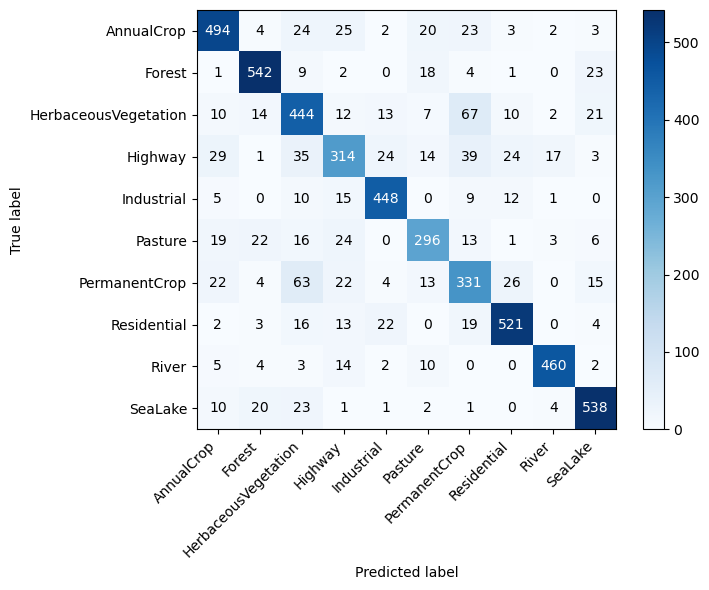

Saved plot -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/cc_1/outputs/plots/confusion_matrix_stats_SVM-RBF_20251210_143936.png


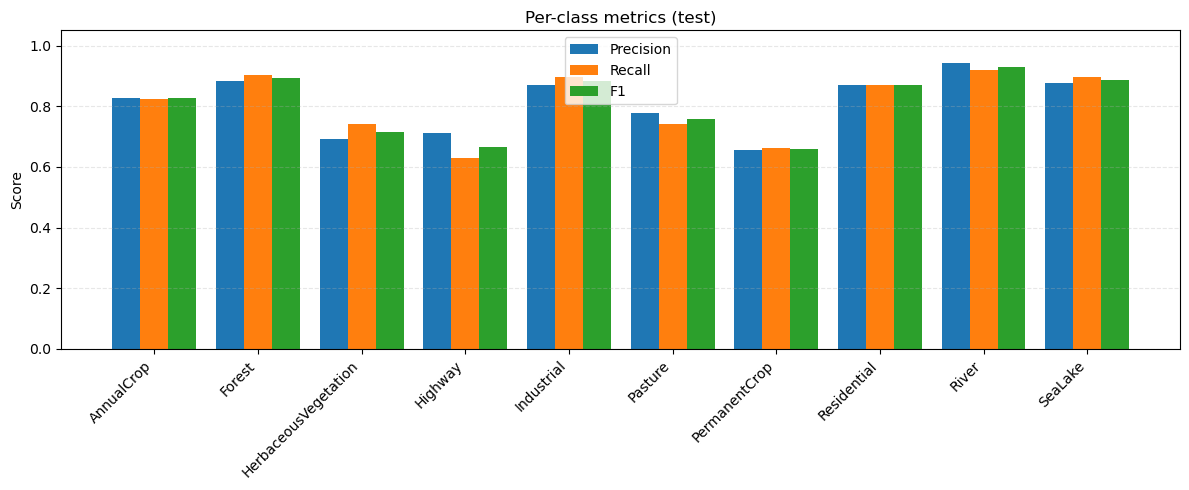

Saved plot -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/cc_1/outputs/plots/per_class_metrics_stats_SVM-RBF_20251210_143936.png


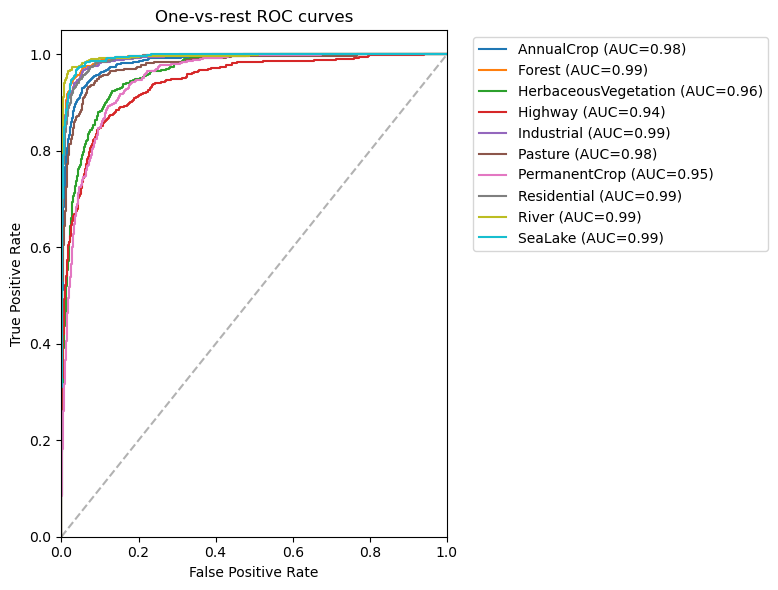

Saved plot -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/cc_1/outputs/plots/roc_curves_stats_SVM-RBF_20251210_143936.png


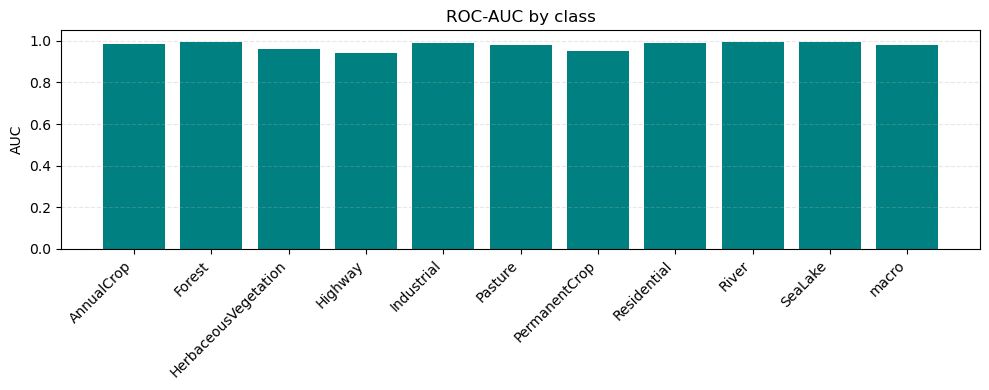

Saved plot -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/cc_1/outputs/plots/roc_auc_stats_SVM-RBF_20251210_143936.png


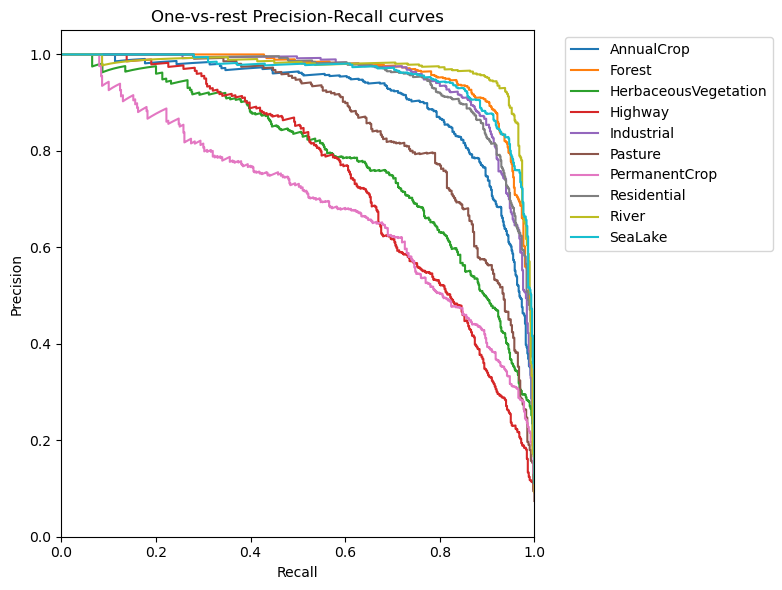

Saved plot -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/cc_1/outputs/plots/precision_recall_stats_SVM-RBF_20251210_143936.png


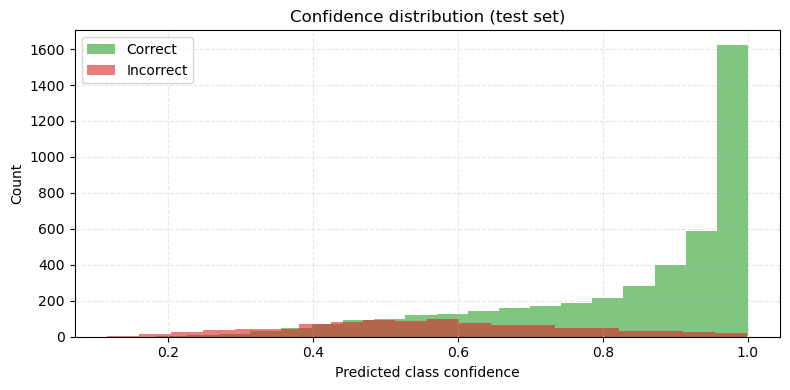

Saved plot -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/cc_1/outputs/plots/score_distribution_stats_SVM-RBF_20251210_143936.png


In [22]:
# Choose the right test features for the winning pipeline
if best_model is None:
    raise RuntimeError("No model trained. Check earlier cells.")

best_name = best[1] or 'model'
use_stats = best_name.startswith("stats::")
Xte = Xte_stats if use_stats else Xte_flat

yhat = best_model.predict(Xte)
print(classification_report(yte, yhat, target_names=CLASS_NAMES))

cm = confusion_matrix(yte, yhat)
plot_tag = f"{best_name.replace('::', '_')}_{RUN_TIMESTAMP}"
_plot_confusion_matrix(cm, CLASS_NAMES, plot_tag)

probs = None
if hasattr(best_model, 'predict_proba'):
    try:
        probs = best_model.predict_proba(Xte)
    except Exception as exc:
        print(f"predict_proba failed: {exc}")
elif hasattr(best_model, 'decision_function'):
    decision = best_model.decision_function(Xte)
    if decision.ndim == 1:
        decision = np.vstack([-decision, decision]).T
    decision -= decision.max(axis=1, keepdims=True)
    exp_scores = np.exp(decision)
    probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
else:
    print('Best model does not expose probabilities; skipping probability-based plots.')

if probs is not None:
    precision, recall, f1, _ = precision_recall_fscore_support(
        yte,
        yhat,
        labels=list(range(len(CLASS_NAMES))),
        zero_division=0,
    )
    _plot_per_class_metrics(precision, recall, f1, CLASS_NAMES, plot_tag)
    auc_scores = _plot_roc_curves(yte, probs, CLASS_NAMES, plot_tag)
    _plot_roc_auc_bars(auc_scores, plot_tag)
    _plot_precision_recall_curves(yte, probs, CLASS_NAMES, plot_tag)
    _plot_score_distribution(yte, yhat, probs, plot_tag)
else:
    print('Skipping ROC/PR curves and score distribution because we lack probability estimates.')


## 8) Notes on Distribution Shift (still relevant)

- Ensure your splits avoid **tile leakage** (images from the same large scene should not be in both train and test).
- Normalize per band using **training-set** statistics only.
- Use augmentations that simulate realistic remote-sensing variability.
- Consider domain adaptation or self-supervised pretraining if the target domain differs significantly.


### Cell 33 – Normalize Kaggle tiles
Implements `normalize_bands` so Kaggle `.npy` tiles share the same scaling as the training GeoTIFFs.


In [23]:
def normalize_bands(arr):
    """Apply the same robust per-band [0,1] scaling used in read_multiband_tif."""
    arr = arr.astype(np.float32, copy=False)
    C, H, W = arr.shape
    for i in range(C):
        band = arr[i]
        lo, hi = np.percentile(band, [2, 98])
        if hi > lo:
            band = (band - lo) / (hi - lo)
        else:
            bmin, bmax = band.min(), band.max()
            band = (band - bmin) / (bmax - bmin + 1e-6)
        arr[i] = np.clip(band, 0.0, 1.0)
    return arr


### Cell 34 – Extract integer IDs
Defines `extract_id` to recover the numeric Kaggle `test_id` from filename stems.


In [24]:
import re
def extract_id(stem):
    m = re.search(r'(\d+)$', str(stem))
    return int(m.group(1)) if m else int(''.join(ch for ch in str(stem) if ch.isdigit()))


### Cell 35 – Locate Kaggle `.npy` tiles
Validates the Kaggle test directory, gathers all `.npy` paths, and prints a preview of the detected files.


In [25]:
TEST_ROOT = KAGGLE_TEST_DIR
if not TEST_ROOT.exists():
    raise FileNotFoundError(f"Expected Kaggle test directory at {TEST_ROOT}")

npy_paths = sorted(TEST_ROOT.glob('*.npy'))
if not npy_paths:
    npy_paths = sorted(TEST_ROOT.glob('**/*.npy'))

print(f"Found {len(npy_paths)} .npy test files")
if npy_paths[:5]:
    print("Examples:", [str(p) for p in npy_paths[:5]])
assert npy_paths, "No .npy files found for Kaggle inference."


Found 4232 .npy test files
Examples: ['/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/kaggle_data/testset/testset/test_0.npy', '/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/kaggle_data/testset/testset/test_1.npy', '/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/kaggle_data/testset/testset/test_10.npy', '/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/kaggle_data/testset/testset/test_100.npy', '/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/kaggle_data/testset/testset/test_1000.npy']


### Cell 36 – Harmonize Kaggle band layouts
Provides `ensure_chw` and `pad_to_13_bands` to reorder/pad tiles so they match the 13-band training layout before feature extraction.


In [26]:
# Ensure (C,H,W) channel-first
def ensure_chw(arr):
    arr = np.asarray(arr)
    if arr.ndim == 2:
        return arr[None, ...]
    if arr.ndim != 3:
        raise ValueError(f"Unsupported array ndim: {arr.ndim}")
    if arr.shape[0] in (len(TEST_BAND_ORDER), len(TRAIN_BAND_ORDER), len(CANONICAL_12_BAND_ORDER)):
        return arr
    if arr.shape[-1] in (len(TEST_BAND_ORDER), len(TRAIN_BAND_ORDER), len(CANONICAL_12_BAND_ORDER)):
        return np.transpose(arr, (2, 0, 1))
    return arr

def pad_to_13_bands(arr, band_order: str | None = None) -> np.ndarray:
    arr = ensure_chw(arr)
    if band_order is None:
        if arr.shape[0] == len(TRAIN_BAND_ORDER):
            band_order = 'train'
        elif arr.shape[0] == len(TEST_BAND_ORDER):
            band_order = 'test'
        elif arr.shape[0] == len(CANONICAL_12_BAND_ORDER):
            band_order = 'canonical_12'
        else:
            raise ValueError(f"Unsupported band layout with shape {arr.shape}")

    if band_order == 'train':
        if arr.shape[0] != len(TRAIN_BAND_ORDER):
            raise ValueError(f"Expected {len(TRAIN_BAND_ORDER)} bands for training layout, got {arr.shape[0]}")
        return arr

    if band_order == 'test':
        canonical = reorder_test_to_canonical(arr)
    elif band_order == 'canonical_12':
        canonical = arr
    else:
        raise ValueError(f"Unsupported band_order={band_order}")

    zero_band = np.zeros_like(canonical[:1])
    return np.concatenate([canonical[:DROP_BAND_INDEX], zero_band, canonical[DROP_BAND_INDEX:]], axis=0)


### Cell 37 – Build Kaggle feature matrices
Normalizes every Kaggle tile, constructs the appropriate feature representation (stats or flattened), and records the tile IDs.


In [27]:
# === 2) Build Kaggle test features ===
if 'best_model' not in globals() or best_model is None:
    raise RuntimeError('Train the models first to obtain best_model')
if 'best' not in globals() or not best or best[1] is None:
    raise RuntimeError("Missing 'best' summary from validation step. Rerun the evaluation cell.")

use_stats = best[1].startswith('stats::')
print("Winning pipeline:", best[1], "| Using", ("stats" if use_stats else "downsampled+PCA"), "features for inference.")

X_stats_test, X_flat_test, test_ids = [], [], []
for path in npy_paths:
    arr = np.load(path, allow_pickle=False)
    arr = pad_to_13_bands(arr, band_order='test')
    arr = normalize_bands(arr)
    if use_stats:
        X_stats_test.append(image_features(arr))
    else:
        X_flat_test.append(downsampled_flat(arr, target=16))
    test_ids.append(extract_id(path.stem))

X_stats_test = np.stack(X_stats_test) if (use_stats and X_stats_test) else None
X_flat_test = np.stack(X_flat_test) if ((not use_stats) and X_flat_test) else None

print("Test feature shapes -> stats:",
      None if X_stats_test is None else X_stats_test.shape,
      "| flat:", None if X_flat_test is None else X_flat_test.shape)


Winning pipeline: stats::SVM-RBF | Using stats features for inference.
Test feature shapes -> stats: (4232, 71) | flat: None


### Cell 38 – Predict Kaggle labels and export submission
Loads the cached features, applies the trained model, and writes `submission_ml_baseline.csv` under the configured output directory.


In [28]:
# === 3) Predict & write submission CSV (match sample_submission.csv) ===
if 'best_model' not in globals() or best_model is None:
    raise RuntimeError('Train the models first to obtain best_model')
if 'X_stats_test' not in globals() and 'X_flat_test' not in globals():
    raise RuntimeError('Run the Kaggle feature-building cell first.')

Xte_kaggle = X_stats_test if use_stats else X_flat_test
assert Xte_kaggle is not None and len(Xte_kaggle) == len(test_ids), "Feature matrix and ID list mismatch."

pred_idx = best_model.predict(Xte_kaggle)
cls_names = CLASS_NAMES if CLASS_NAMES else None
pred_label = [cls_names[i] if (cls_names and i < len(cls_names)) else str(int(i)) for i in pred_idx]

submission = pd.DataFrame({'test_id': test_ids, 'label': pred_label})
submission = submission.sort_values('test_id').reset_index(drop=True)

sub_path = OUTPUT_DIR / 'submission_ml_baseline.csv'
submission.to_csv(sub_path, index=False)
print("Saved submission to", sub_path)

try:
    print("Model n_features_in_:", getattr(best_model, 'n_features_in_', 'n/a'))
    print("Built features:", Xte_kaggle.shape[1])
    print("Submission shape:", submission.shape)
    print(submission.head())
except Exception as exc:
    print("Info check skipped:", exc)


Saved submission to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/cc_1/outputs/submission_ml_baseline.csv
Model n_features_in_: 71
Built features: 71
Submission shape: (4232, 2)
   test_id       label
0        0  AnnualCrop
1        1  AnnualCrop
2        2  AnnualCrop
3        3     SeaLake
4        4  AnnualCrop
